In [1]:
import glob

import numpy as np
import scipy.optimize as op

import matplotlib.pyplot as plt
import matplotlib as mpl

import astropy.units as u

import emcee

from dust_extinction.averages import G03_SMCBar
from dust_extinction.parameter_averages import G23

from measure_extinction.stardata import StarData
from measure_extinction.extdata import ExtData
from measure_extinction.modeldata import ModelData
from measure_extinction.utils.fit_model import FitInfo

from measure_extinction.utils.helpers import get_full_starfile
from measure_extinction.utils.fit_model import get_best_fit_params, get_percentile_params

Specify the location of the model and observed data

In [2]:
data_file_path = "/home/kgordon/STScI/AbsFlux/CalSpec/absflux_fitseds/data/faintwds/"
model_file_path = "/home/kgordon/Python/extstar_data/"

Define star specific parameters

In [3]:
starname = "wdfs2351_37"
fstarname = f"{starname}.dat"
velocity = 0.0   # assumption
relband = "WFC3_F625W"

Read in the star data

In [4]:
# get the observed reddened star data
reddened_star = StarData(fstarname, path=f"{data_file_path}")
band_names = reddened_star.data["BAND"].get_band_names()
data_names = reddened_star.data.keys()

Plot the spectrum

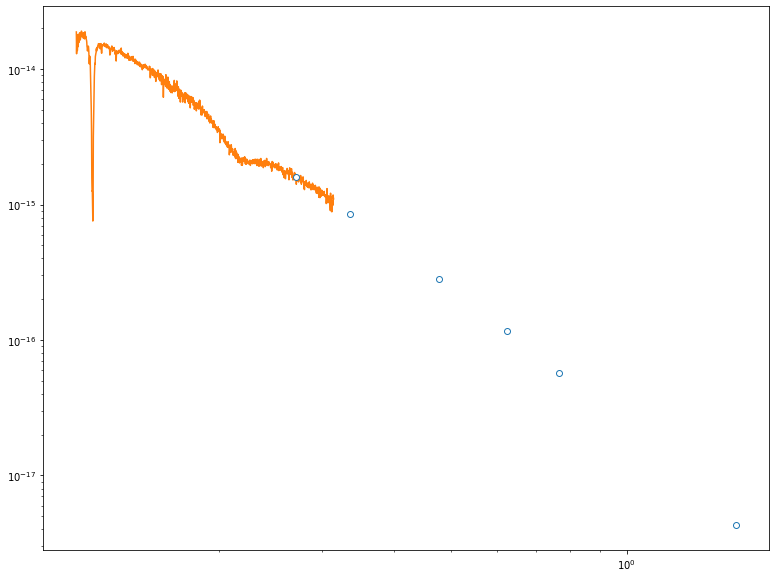

In [5]:
fig, ax = plt.subplots(figsize=(13, 10))
reddened_star.plot(ax)
ax.set_xscale("log")
ax.set_yscale("log")

Get the model data

In [6]:
tlusty_models_fullpath = glob.glob(f"{model_file_path}/Models/wd_hubeny*.dat")
# tlusty_models_fullpath = tlusty_models_fullpath[0:10]
tlusty_models = [
    tfile[tfile.rfind("/") + 1 : len(tfile)] for tfile in tlusty_models_fullpath
]

# get the models with just the reddened star band data and spectra
modinfo = ModelData(
    tlusty_models,
    path=f"{model_file_path}/Models/",
    band_names=band_names,
    spectra_names=data_names,
)

In [7]:
def plot_data_model(reddened_star, modinfo, params):

    # intrinsic sed
    modsed = modinfo.stellar_sed(params[0:3], velocity=velocity)

    # dust_extinguished sed
    ext_modsed = modinfo.dust_extinguished_sed(params[3:10], modsed)

    # hi_abs sed
    hi_ext_modsed = modinfo.hi_abs_sed(
        params[10:12], [velocity, 0.0], ext_modsed
    )

    # create a StarData object for the best fit SED
    #modsed_stardata = modinfo.SED_to_StarData(modsed)

    norm_model = np.average(hi_ext_modsed["BAND"])
    norm_data = np.average(reddened_star.data["BAND"].fluxes).value

    # plotting setup for easier to read plots
    fontsize = 18
    font = {"size": fontsize}
    mpl.rc("font", **font)
    mpl.rc("lines", linewidth=1)
    mpl.rc("axes", linewidth=2)
    mpl.rc("xtick.major", width=2)
    mpl.rc("xtick.minor", width=2)
    mpl.rc("ytick.major", width=2)
    mpl.rc("ytick.minor", width=2)

    # setup the plot
    fig, axes = plt.subplots(nrows=2, figsize=(13, 10), gridspec_kw={'height_ratios': [3, 1]}, sharex=True)

    # plot the bands and all spectra for this star
    ax = axes[0]
    for cspec in modinfo.fluxes.keys():
        if cspec == "BAND":
            ptype = "o"
        else:
            ptype = "-"

        # ax.plot(reddened_star.data[cspec].waves,
        #        weights[cspec], 'k-')

        ax.plot(
            reddened_star.data[cspec].waves,
            reddened_star.data[cspec].fluxes,
            "k" + ptype,
            label="data",
        )

        # print(reddened_star.data[cspec].waves)
        # print(modinfo.waves[cspec])

        ax.plot(
            modinfo.waves[cspec], modsed[cspec] * norm_data / norm_model, "b" + ptype, label=cspec
        )
        ax.plot(
            modinfo.waves[cspec],
            ext_modsed[cspec] * norm_data / norm_model,
            "r" + ptype,
            label=cspec,
        )
        modspec = hi_ext_modsed[cspec] * norm_data / norm_model
        ax.plot(
            modinfo.waves[cspec],
            modspec,
            "g" + ptype,
            label=cspec,
        )
        
        diff = (reddened_star.data[cspec].fluxes.value - modspec) / modspec
        axes[1].plot(reddened_star.data[cspec].waves, diff, "k" + ptype)

        
    # finish configuring the plot
    ax.set_ylim(8e4 * norm_data / norm_model, 2e10 * norm_data / norm_model)
    ax.set_yscale("log")
    ax.set_xscale("log")
    axes[1].set_xlabel(r"$\lambda$ [$\mu m$]", fontsize=1.3 * fontsize)
    ax.set_ylabel(r"$F(\lambda)$ [$ergs\ cm^{-2}\ s\ \AA$]", fontsize=1.3 * fontsize)
    ax.tick_params("both", length=10, width=2, which="major")
    ax.tick_params("both", length=5, width=1, which="minor")
    axes[1].set_ylim(-0.1, 0.1)
    axes[1].plot([0.1, 2.5], [0.0, 0.0], "k:")

    # ax.legend()

    # use the whitespace better
    fig.tight_layout()

Setup the fit parameters

In [8]:
# parameter names
pnames = ["logT","logg", "logZ", "Av","Rv","C2","C3","C4","x0","gamma","HI_gal","HI_mw"]
pnames_fit = ["logT","logg", "Av","Rv","C2","C3","C4","x0","gamma","HI_gal"]

# initial starting position
params = [4.5, 7.5, 0.0, 0.5, 3.1, 0.7, 3.23, 0.41, 4.59, 0.95, 20.5, 17.0]

# min/max allowed values for each parameter
# some are based on the min/max of the stellar atmosphere grid

# not all these parameters are being fit
#   not fitting for met, log(HI) MW foreground
plimits = [
        [modinfo.temps_min, modinfo.temps_max],  # log(Teff)
        [modinfo.gravs_min, modinfo.gravs_max],  # log(g)
        [0.0, 0.0], # met
        [0.0, 1.0],   # Av
        [2.31, 5.59],   # Rv
        [-0.1, 5.0],  # C2
        [-1.0, 6.0],   # C3
        [-0.5, 1.5],   # C4
        [4.5, 4.9],   # xo
        [0.6, 1.5],   # gamma
        [18.0, 24.0], # log(HI) internal to galaxy
        [17.0, 22.0], # log(HI) MW foreground
    ]

# add Gaussian priors based on prior knowledge
#  sptype -> log(Teff), log(g)
#  galaxy metallicity -> log(Z)
ppriors = None
# ppriors = {}
#ppriors["logT"] = (params[0], 0.1)
#ppriors["logg"] = (3.1, 0.1)

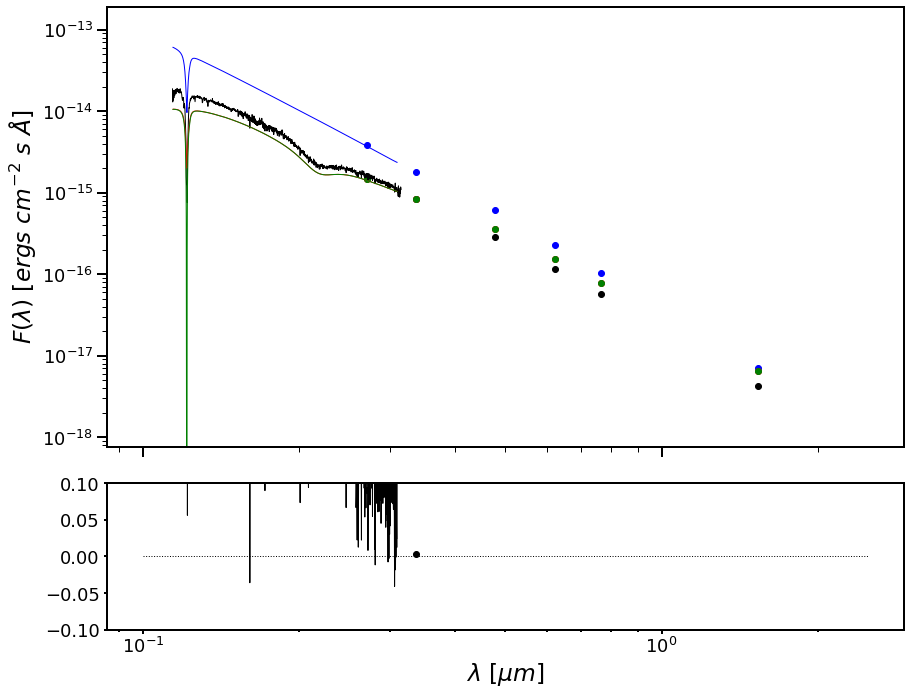

In [9]:
# plot initial guess
plot_data_model(reddened_star, modinfo, params)

Create the weight arrays based on the observed uncertainties

In [10]:
# cropping info for weights
#  bad regions are defined as those were we know the models do not work
#  or the data is bad
ex_regions = [
    [8.23 - 0.1, 8.23 + 0.1],  # geocoronal line
    [8.7, 10.0],  # bad data from STIS
    [3.55, 3.6],
    [3.80, 3.90],
    [4.15, 4.3],
    [6.4, 6.6],
    [7.1, 7.3],
    [7.45, 7.55],
    [7.65, 7.75],
    [7.9, 7.95],
    [8.05, 8.1],
] / u.micron

weights = {}
for cspec in data_names:
    weights[cspec] = np.full(len(reddened_star.data[cspec].fluxes), 0.0)
    gvals = reddened_star.data[cspec].npts > 0

    weights[cspec][gvals] = 1.0 / reddened_star.data[cspec].uncs[gvals].value

    x = 1.0 / reddened_star.data[cspec].waves
    for cexreg in ex_regions:
        weights[cspec][np.logical_and(x >= cexreg[0], x <= cexreg[1])] = 0.0

# make the photometric bands have higher weight
#weights["BAND"] *= 10000.0

Package the fit info needed.  FitInfo class defines the likelihood functions as well.

In [11]:
fitinfo = FitInfo(
    pnames,
    plimits,
    weights,
    parameter_priors=ppriors,
    stellar_velocity=velocity,
)

In [12]:
# check that the initial starting position returns a valid value of lnprob and is within the parameter bounds
fitinfo.check_param_limits(params)
print(fitinfo.lnlike(params, reddened_star, modinfo))
print(fitinfo.lnprior(params))
print(fitinfo.lnprob(params, reddened_star, modinfo, fitinfo))

-63885.75623623792
0.0
-63885.75623623792


In [13]:
def get_full_params(params):
    full_params = np.zeros(len(params) + 2)
    full_params[0:2] = params[0:2]
    full_params[3:-1] = params[2:]
    full_params[-1] = 17.0
    
    return full_params

def get_fit_params(params):
    fit_params = np.zeros(len(params) - 2)
    fit_params[0:2] = params[0:2]
    fit_params[2:] = params[3:-1]

    return fit_params

Useful function to plot data and model for specificed parameters

In [14]:
# simple function to turn the log(likelihood) into the chisqr
#  requied as op.minimize function searchs for the minimum chisqr (not max likelihood like MCMC algorithms)
def nll(params, *args):
    full_params = get_full_params(params)
    return -fitinfo.lnprob(full_params, *args)

init_fit_params = get_fit_params(params)

# run the fit
result = op.minimize(
    nll, init_fit_params, method="Nelder-Mead", options={"maxiter": 10000}, args=(reddened_star, modinfo, fitinfo)
)

# check the fit output
print(result["message"])

Optimization terminated successfully.


In [15]:
# save results
fit_params = get_full_params(result["x"])
params_best = fit_params
pnames_extra = pnames

# print the best fit
for k, val in enumerate(params_best):
    print("{} # {}".format(val, pnames_extra[k]))


4.812913354975928 # logT
8.500000041789974 # logg
0.0 # logZ
0.4488152895814957 # Av
3.4751936155946765 # Rv
0.6981031435259989 # C2
3.2925623276533487 # C3
0.3105899728756218 # C4
4.608357951741715 # x0
0.9547967060710902 # gamma
20.78186838665762 # HI_gal
17.0 # HI_mw


Calculate the best fit model SED

In [16]:
# intrinsic sed
modsed = modinfo.stellar_sed(fit_params[0:3], velocity=velocity)

# dust_extinguished sed
ext_modsed = modinfo.dust_extinguished_sed(fit_params[3:10], modsed)

# hi_abs sed
hi_ext_modsed = modinfo.hi_abs_sed(
    fit_params[10:12], [velocity, 0.0], ext_modsed
)

# create a StarData object for the best fit SED
modsed_stardata = modinfo.SED_to_StarData(modsed)

Plot the spectra

/tmp/ipykernel_104552/4238103504.py:72: RuntimeWarning: divide by zero encountered in divide
  diff = (reddened_star.data[cspec].fluxes.value - modspec) / modspec


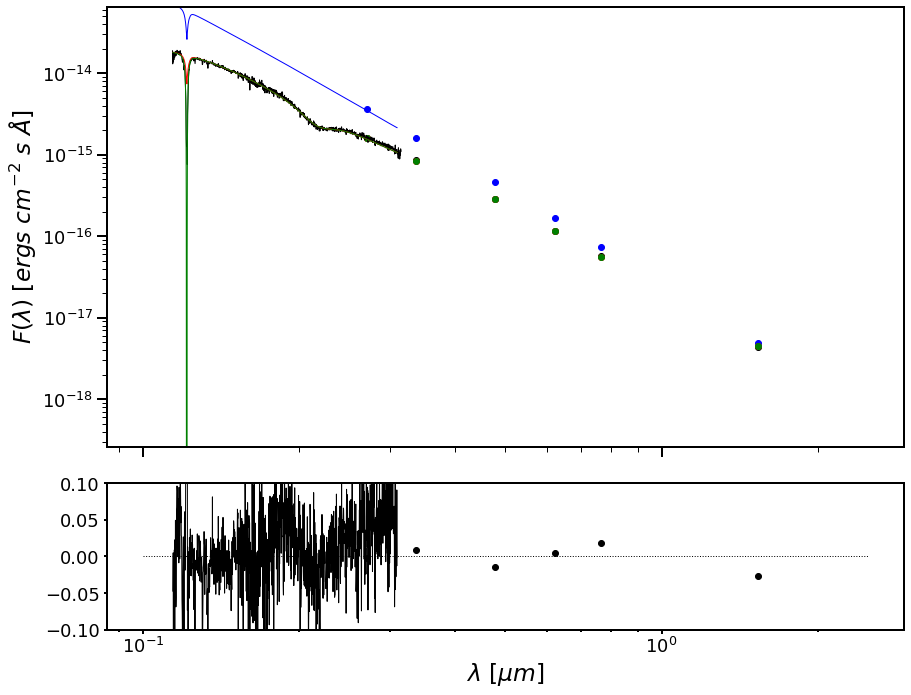

In [17]:
# plot optimizer/minimizer best fit
plot_data_model(reddened_star, modinfo, fit_params)

Run emcee MCMC sampler to define uncertainties (bonus section)

In [25]:
p0 = get_fit_params(fit_params)
ndim = len(p0)

def lnprob_mcmc(params, *args):
    full_params = get_full_params(params)
    return fitinfo.lnprob(full_params, *args)

nwalkers = 2 * ndim
nsteps = 10000

# setting up the walkers to start "near" the inital guess
p = [p0 * (1 + 0.01 * np.random.normal(0, 1.0, ndim)) for k in range(nwalkers)]

# setup the sampler
sampler = emcee.EnsembleSampler(
    nwalkers, ndim, lnprob_mcmc, args=(reddened_star, modinfo, fitinfo)
)

# do the full sampling
pos, prob, state = sampler.run_mcmc(p, nsteps, progress=True)

  0%|                                                                                               | 0/10000 [00:00<?, ?it/s]/home/kgordon/Bin/miniconda3/lib/python3.9/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
100%|███████████████████████████████████████████████████████████████████████████████████| 10000/10000 [44:35<00:00,  3.74it/s]


In [31]:
# create the samples variable for later use
flat_samples = sampler.get_chain(discard=1000, flat=True)
print(flat_samples.shape)

# get the best fit values
# pnames_extra = pnames + ["E(B-V)", "N(HI)/A(V)", "N(HI)/E(B-V)"]
params_best = get_best_fit_params(sampler)
# fit_params = get_full_params(params_best)

def get_percentile_params(samples):
    """
    Determine the 50p plus/minus 33p vlaues
    """

    per_params = map(
        lambda v: (v[1], v[2] - v[1], v[1] - v[0]),
        zip(*np.percentile(samples, [16, 50, 84], axis=0)),
    )

    return per_params

# get the 16, 50, and 84 percentiles
params_per = get_percentile_params(flat_samples)

# save the best fit and p50 +/- uncs values to a file
# save as a single row table to provide a uniform format
#f = open(out_basename + "_fit_params.dat", "w")
#f.write("# best fit, p50, +unc, -unc\n")
print("best p50 -munc +unc # paramname")
for k, val in enumerate(params_per):
    print(f"{params_best[k]:.3f} {val[0]:.3f} {val[1]:.3f} {val[2]:.3f} # {pnames_fit[k]}")

(180000, 10)
best p50 -munc +unc # paramname
4.959 4.877 0.062 0.062 # logT
9.481 9.423 0.057 0.087 # logg
0.419 0.411 0.010 0.011 # Av
2.676 2.751 0.092 0.080 # Rv
0.711 0.688 0.016 0.017 # C2
1.821 1.911 0.108 0.094 # C3
0.196 0.209 0.016 0.015 # C4
4.612 4.611 0.004 0.005 # x0
0.762 0.764 0.015 0.015 # gamma
20.726 20.492 0.212 0.921 # HI_gal


In [32]:
fit_params = get_full_params(params_best)

# intrinsic sed
modsed = modinfo.stellar_sed(fit_params[0:3], velocity=velocity)

# dust_extinguished sed
ext_modsed = modinfo.dust_extinguished_sed(fit_params[3:10], modsed)

# hi_abs sed
hi_ext_modsed = modinfo.hi_abs_sed(
    fit_params[10:12], [velocity, 0.0], ext_modsed
)

/tmp/ipykernel_104552/4238103504.py:72: RuntimeWarning: divide by zero encountered in divide
  diff = (reddened_star.data[cspec].fluxes.value - modspec) / modspec


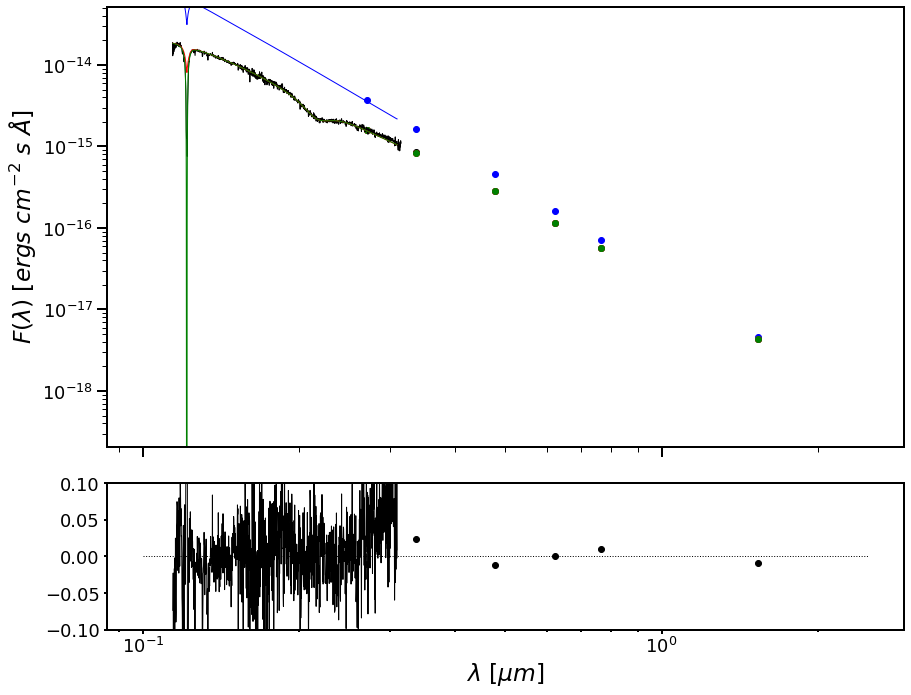

In [33]:
plot_data_model(reddened_star, modinfo, fit_params)

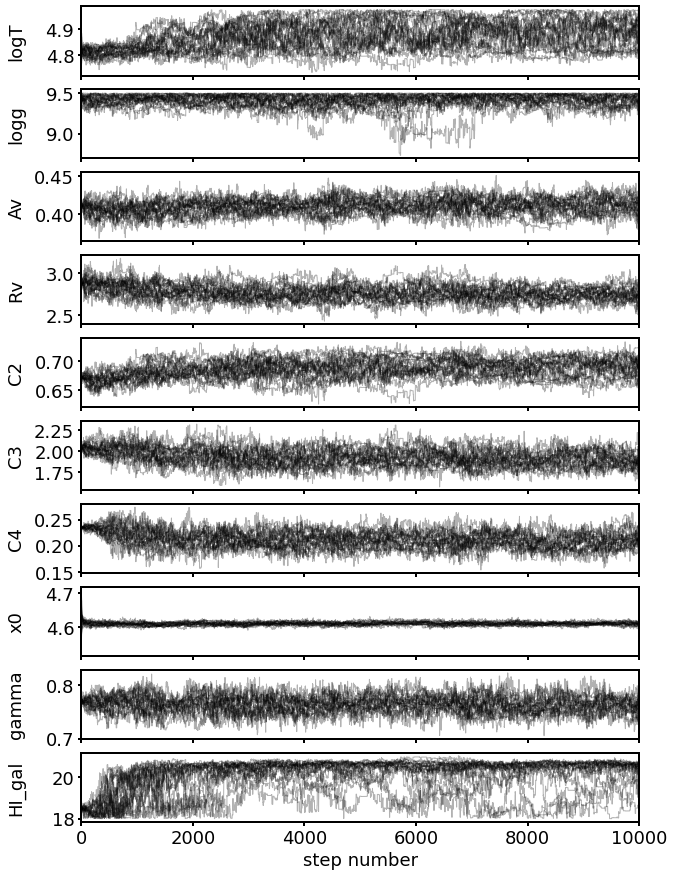

In [34]:
nparam = len(params_best)
fig, axes = plt.subplots(nparam, figsize=(10, 15), sharex=True)
samples = sampler.get_chain()
labels = pnames_fit
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

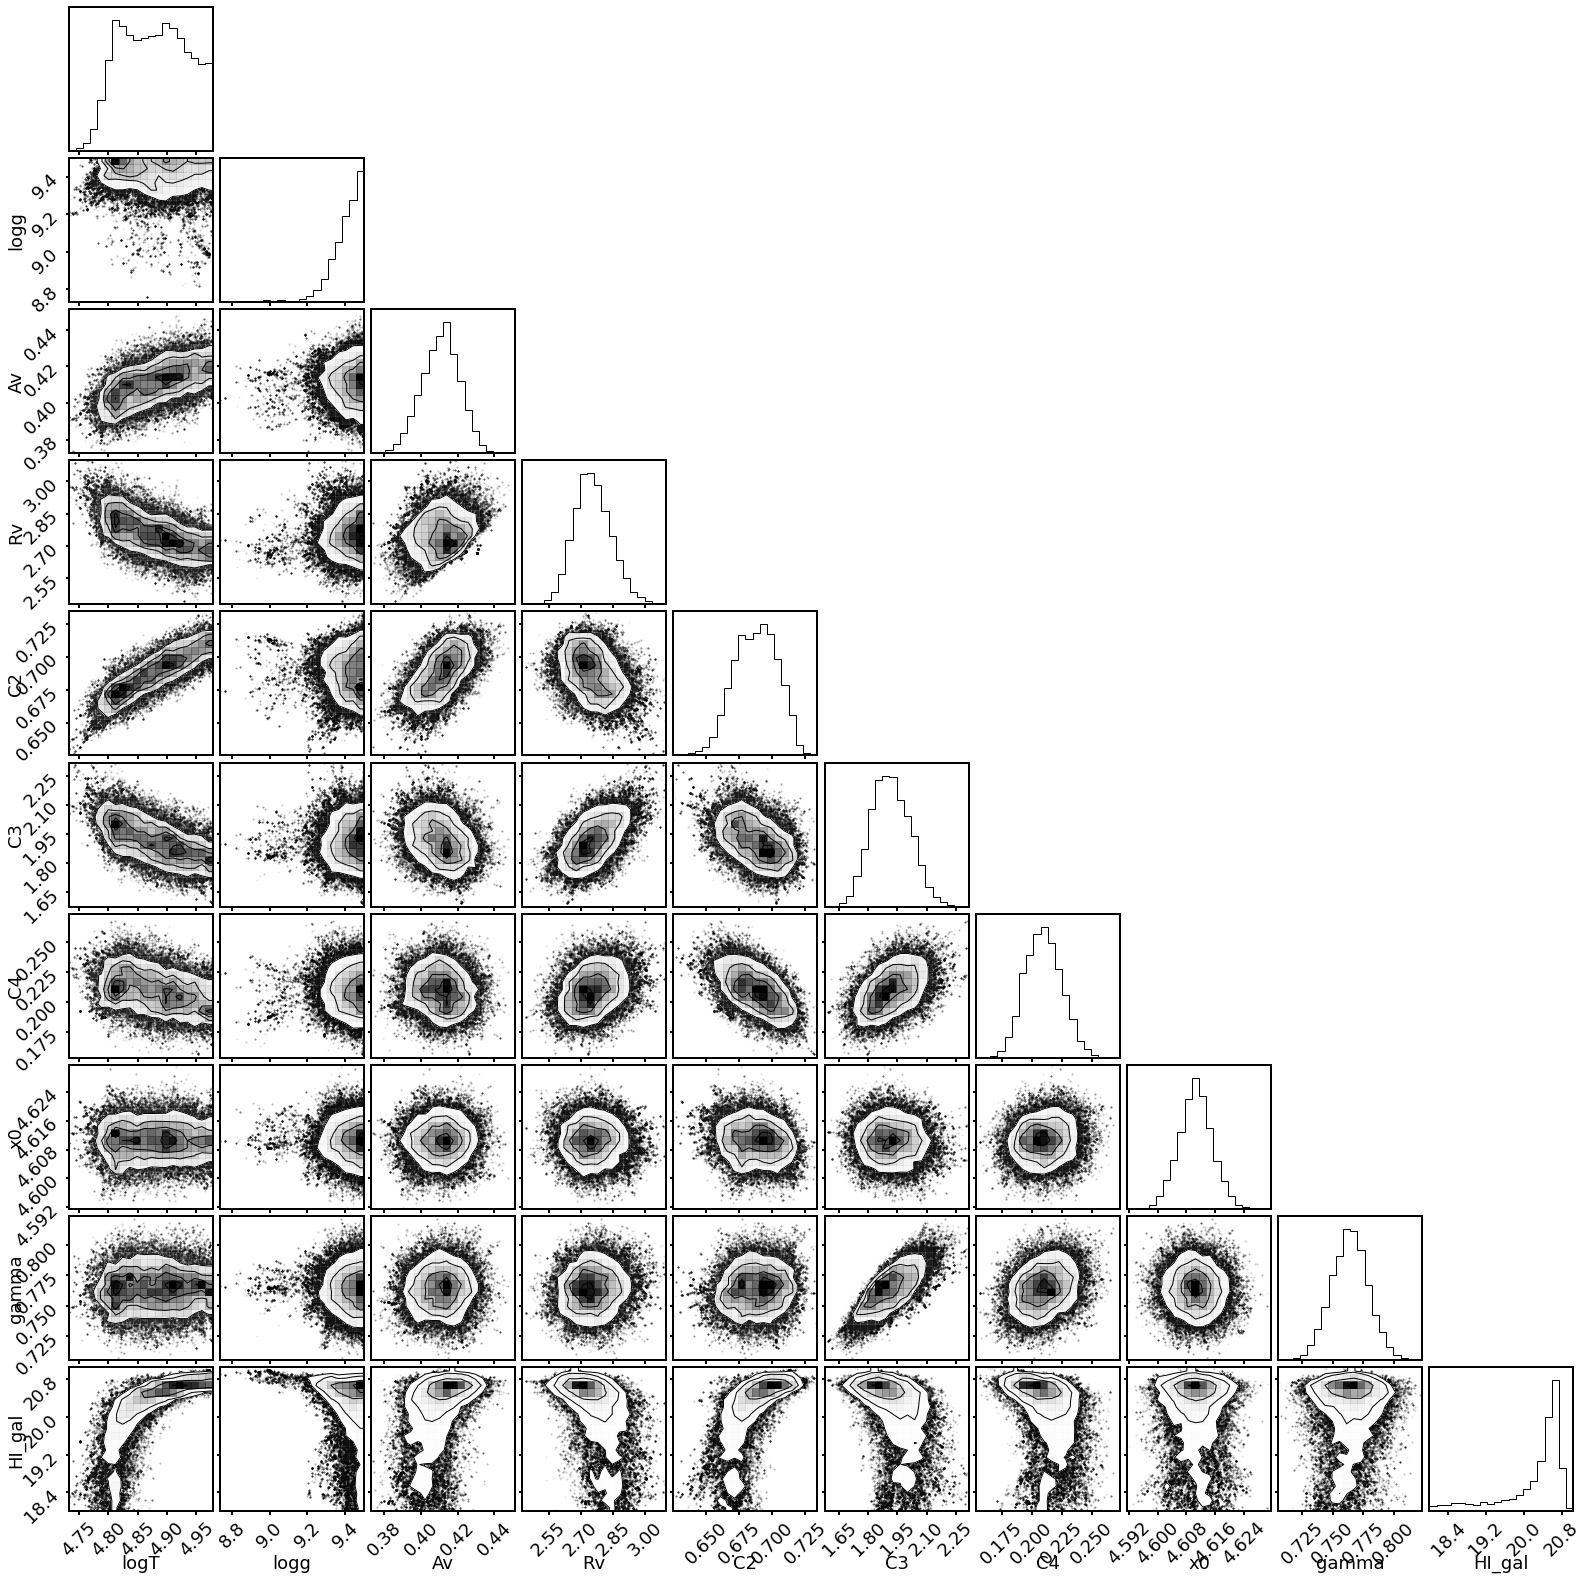

In [35]:
import corner

fig = corner.corner(flat_samples, labels=labels)

In [ ]:
tau = sampler.get_autocorr_time()
print(tau)